In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

%matplotlib inline

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    from ysi_utils.models import outlier_model, bagging_model, ensemble_predict
    ensemble_predict.bagging_model = bagging_model()

Using Theano backend.


In [3]:
from ysi_utils.data import low
from ysi_utils.descriptors import dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

y_test_predictions = ensemble_predict(X_test)
y_train_predictions = ensemble_predict(X.values)

y['inlier'] = outlier_model.predict(X) == 1
y_test['inlier'] = outlier_model.predict(X_test) == 1

high = pd.read_pickle('high.p')
high['YSIl'] = (high.YSI - 16.9) / 0.1331

new_descriptors = pd.read_csv('new_mols.tsv', sep='\t', index_col=0).set_index('NAME', drop=True)
new_descriptors = new_descriptors.loc[high.SMILES]

predictions = ensemble_predict(new_descriptors)

In [4]:
valid_classes = outlier_model.predict(X)
valid_classes_test = outlier_model.predict(X_test)

y['inlier'] = (valid_classes == 1)
y_test['inlier'] = (valid_classes_test == 1)

high_inliers = outlier_model.predict(new_descriptors) == 1

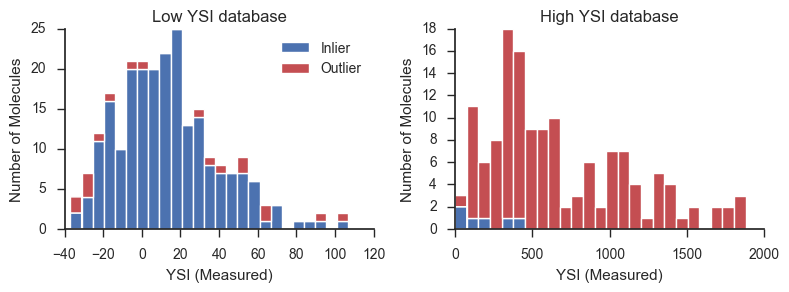

In [5]:
with sns.axes_style('ticks'):
    fig, axmatrix = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    
    
    axmatrix[0].hist([y.YSI[y.inlier], y.YSI[~y.inlier]],
                     stacked=True, bins=25, rwidth=1., edgecolor='w',
                     linewidth=1., color=['b','r'], label=['Inlier', 'Outlier'])
    
    axmatrix[1].hist([high.YSIl[high_inliers], high.YSIl[~high_inliers]],
                     stacked=True, bins=25, rwidth=1., edgecolor='w',
                     linewidth=1., color=['b','r'])
    
    fig.tight_layout()
    sns.despine()
    
    axmatrix[0].set_title('Low YSI database')
    axmatrix[1].set_title('High YSI database')
    
    axmatrix[0].set_ylabel('Number of Molecules')
    axmatrix[1].set_ylabel('Number of Molecules')

    axmatrix[0].set_xlabel('YSI (Measured)')
    axmatrix[1].set_xlabel('YSI (Measured)')
    
    axmatrix[0].legend(loc='upper right')
    
    fig.tight_layout()
    fig.savefig('old_outlier_detection.svg', transparent=True)

In [15]:
import numpy as np
np.random.seed(0)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Descriptor outlier classification
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

outlier_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('filter', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('feature_extraction', PCA(n_components=5)),
    ('outlier_clf', IsolationForest(contamination=0.1)),
        ])

outlier_pipeline.fit(X.values, y.values)
valid_classes = outlier_pipeline.predict(X)
valid_classes_test = outlier_pipeline.predict(X_test)

y['inlier'] = (valid_classes == 1)
y_test['inlier'] = (valid_classes_test == 1)

high_inliers = outlier_pipeline.predict(new_descriptors) == 1

In [16]:
(valid_classes == 1).sum() / len(valid_classes)

0.89915966386554624

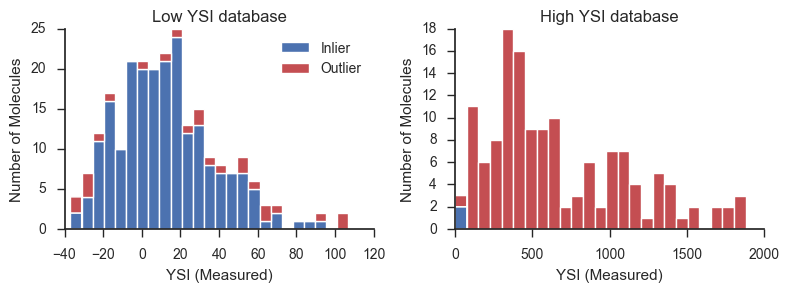

In [7]:
with sns.axes_style('ticks'):
    fig, axmatrix = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    
    
    axmatrix[0].hist([y.YSI[y.inlier], y.YSI[~y.inlier]],
                     stacked=True, bins=25, rwidth=1., edgecolor='w',
                     linewidth=1., color=['b','r'], label=['Inlier', 'Outlier'])
    
    axmatrix[1].hist([high.YSIl[high_inliers], high.YSIl[~high_inliers]],
                     stacked=True, bins=25, rwidth=1., edgecolor='w',
                     linewidth=1., color=['b','r'])
    
    fig.tight_layout()
    sns.despine()
    
    axmatrix[0].set_title('Low YSI database')
    axmatrix[1].set_title('High YSI database')
    
    axmatrix[0].set_ylabel('Number of Molecules')
    axmatrix[1].set_ylabel('Number of Molecules')

    axmatrix[0].set_xlabel('YSI (Measured)')
    axmatrix[1].set_xlabel('YSI (Measured)')
    
    axmatrix[0].legend(loc='upper right')

    fig.tight_layout()
    #fig.savefig('new_outlier_detection.svg', transparent=True)

In [8]:
(valid_classes == 1).sum() / len(valid_classes)

0.89915966386554624

In [9]:
(valid_classes_test == 1).sum() / len(valid_classes_test)

0.89830508474576276